Visualizations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

KDE Z-scores

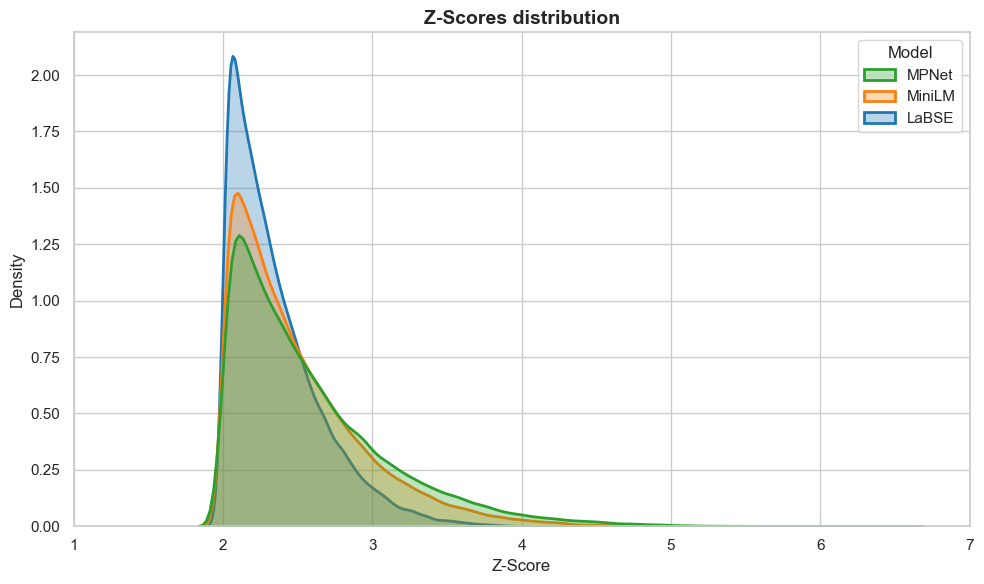

In [2]:
filename = "normalized_similarity_results.csv"
df_vis = pd.read_csv(filename)
sns.set_theme(style="whitegrid")
model_colors = {"LaBSE": "tab:blue", "MiniLM": "tab:orange", "MPNet": "tab:green"}

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_vis, 
    x="Z_Score", 
    hue="Model", 
    fill=True, 
    common_norm=False, #important for density plots
    palette=model_colors,
    alpha=0.3,
    linewidth=2
)
plt.title("Z-Scores distribution", fontsize=14, fontweight='bold')
plt.xlabel("Z-Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(1, 7) 
plt.savefig('Z_score_distribution.png')
plt.tight_layout()

In [3]:
#From here onwards, we focus on MPNet model only. This is the best performing model.


#defining mp indexes to site names
mp_mapping = {
    0: "Colonies of Benevolence",
    1: "Frontiers of the Roman Empire - The Lower German Limes",
    2: "Eise Eisinga Planetarium in Franeker",
    3: "Dutch Water Defence Lines",
    4: "The Wadden Sea",
    5: "The seventeenth-century canal ring area of Amsterdam inside the Singelgracht",
    6: "Van Nellefabriek",
    7: "Schokland and surroundings",
    8: "Mill Network at Kinderdijk-Elshout",
    9: "Droogmakerij de Beemster",
    10: "Rietveld Schröder House"
}

#Filtering for MPNet model
df_mpnet = df_vis[df_vis['Model'] == 'MPNet']

Top Concepts per Management plan

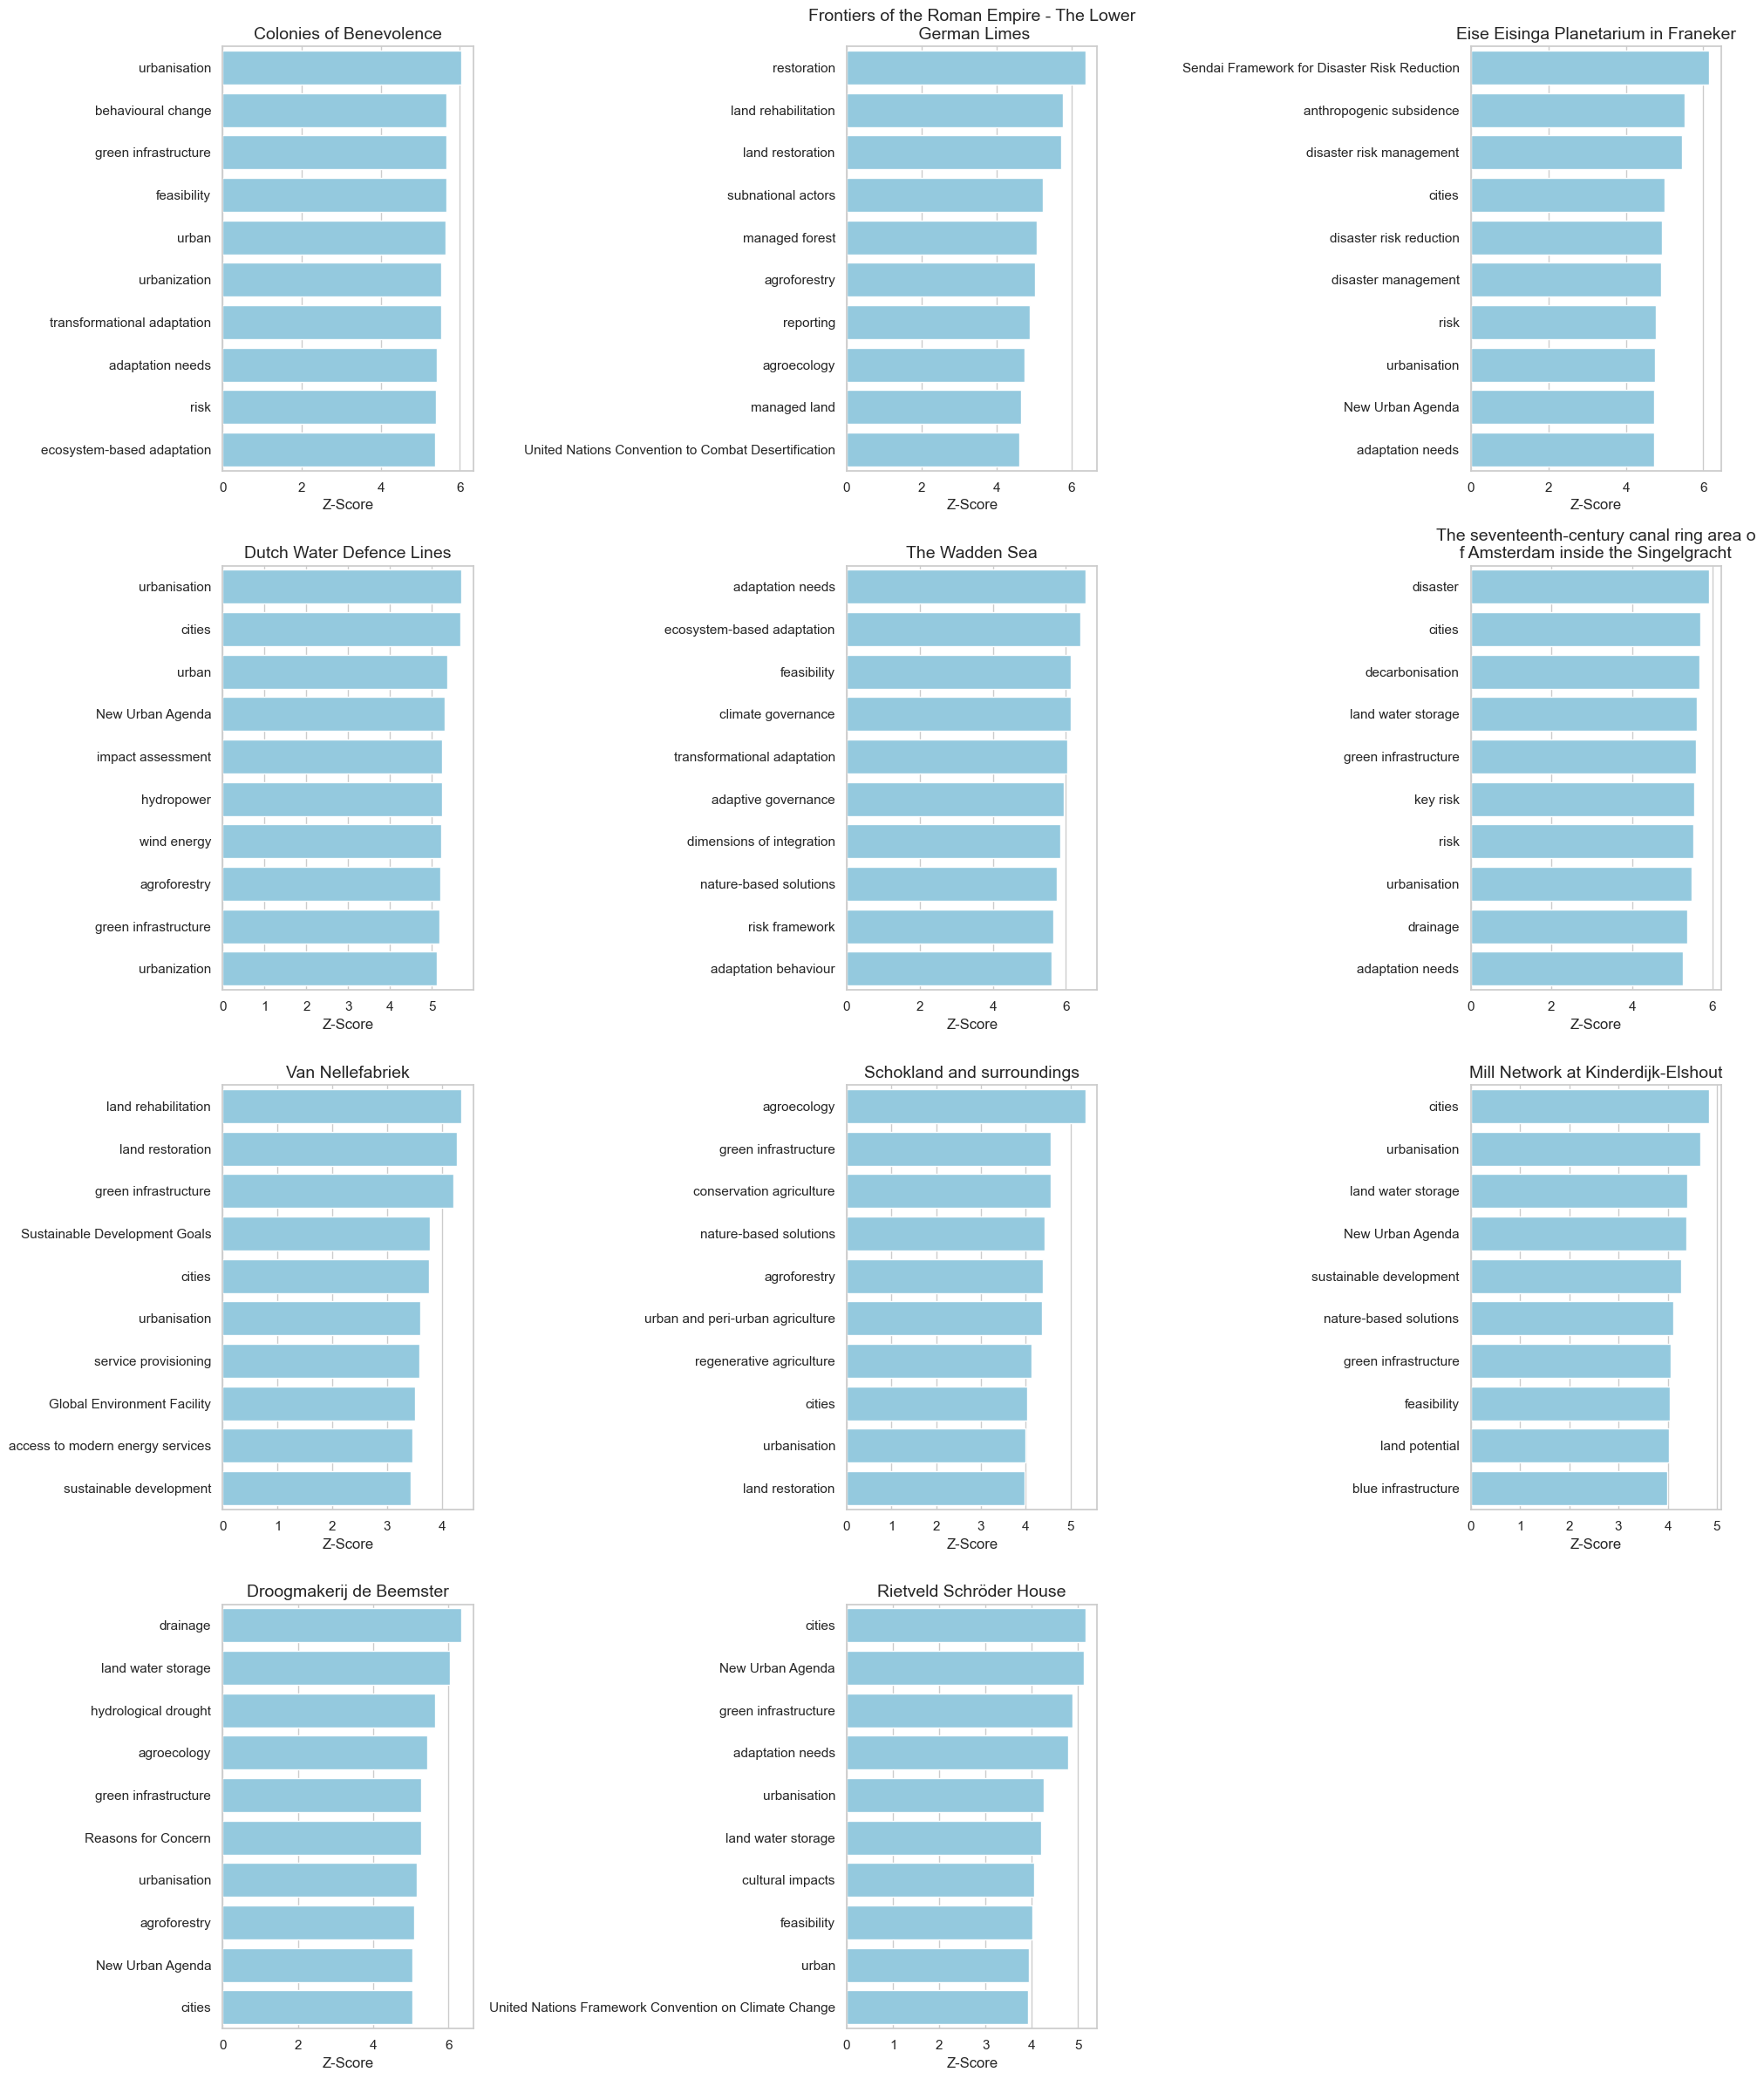

In [4]:
#getting max z-scores per concept per mp index
df_grouped = df_mpnet.groupby(['MP Index', 'Concept'])['Z_Score'].max().reset_index()

# Sorting and taking the top 10 per MP Index
top_concepts = df_grouped.sort_values(
    ['MP Index', 'Z_Score'], 
    ascending=[True, False]
).groupby('MP Index').head(10)

# Creating the visualization
unique_mps = sorted(top_concepts['MP Index'].unique())
n_cols = 3
n_rows = (len(unique_mps) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=False)
axes = axes.flatten()

# Plotting each MP Index in its own subplot
for i, mp_idx in enumerate(unique_mps):
    ax = axes[i]
    data = top_concepts[top_concepts['MP Index'] == mp_idx]
    
    # Creating horizontal bar chart
    sns.barplot(x='Z_Score', y='Concept', data=data, ax=ax, color='skyblue')
    
    # Getting the site name and wrap it if it's too long
    site_name = mp_mapping.get(mp_idx, f"MP Index {mp_idx}")
    title = "\n".join([site_name[i:i+41] for i in range(0, len(site_name), 41)])
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Z-Score')
    ax.set_ylabel('')

# Remove any unused subplots (the twelfth subplot in this case)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('top_concepts_per_site_mpnet.png')
plt.show()

Most concept matches per MP

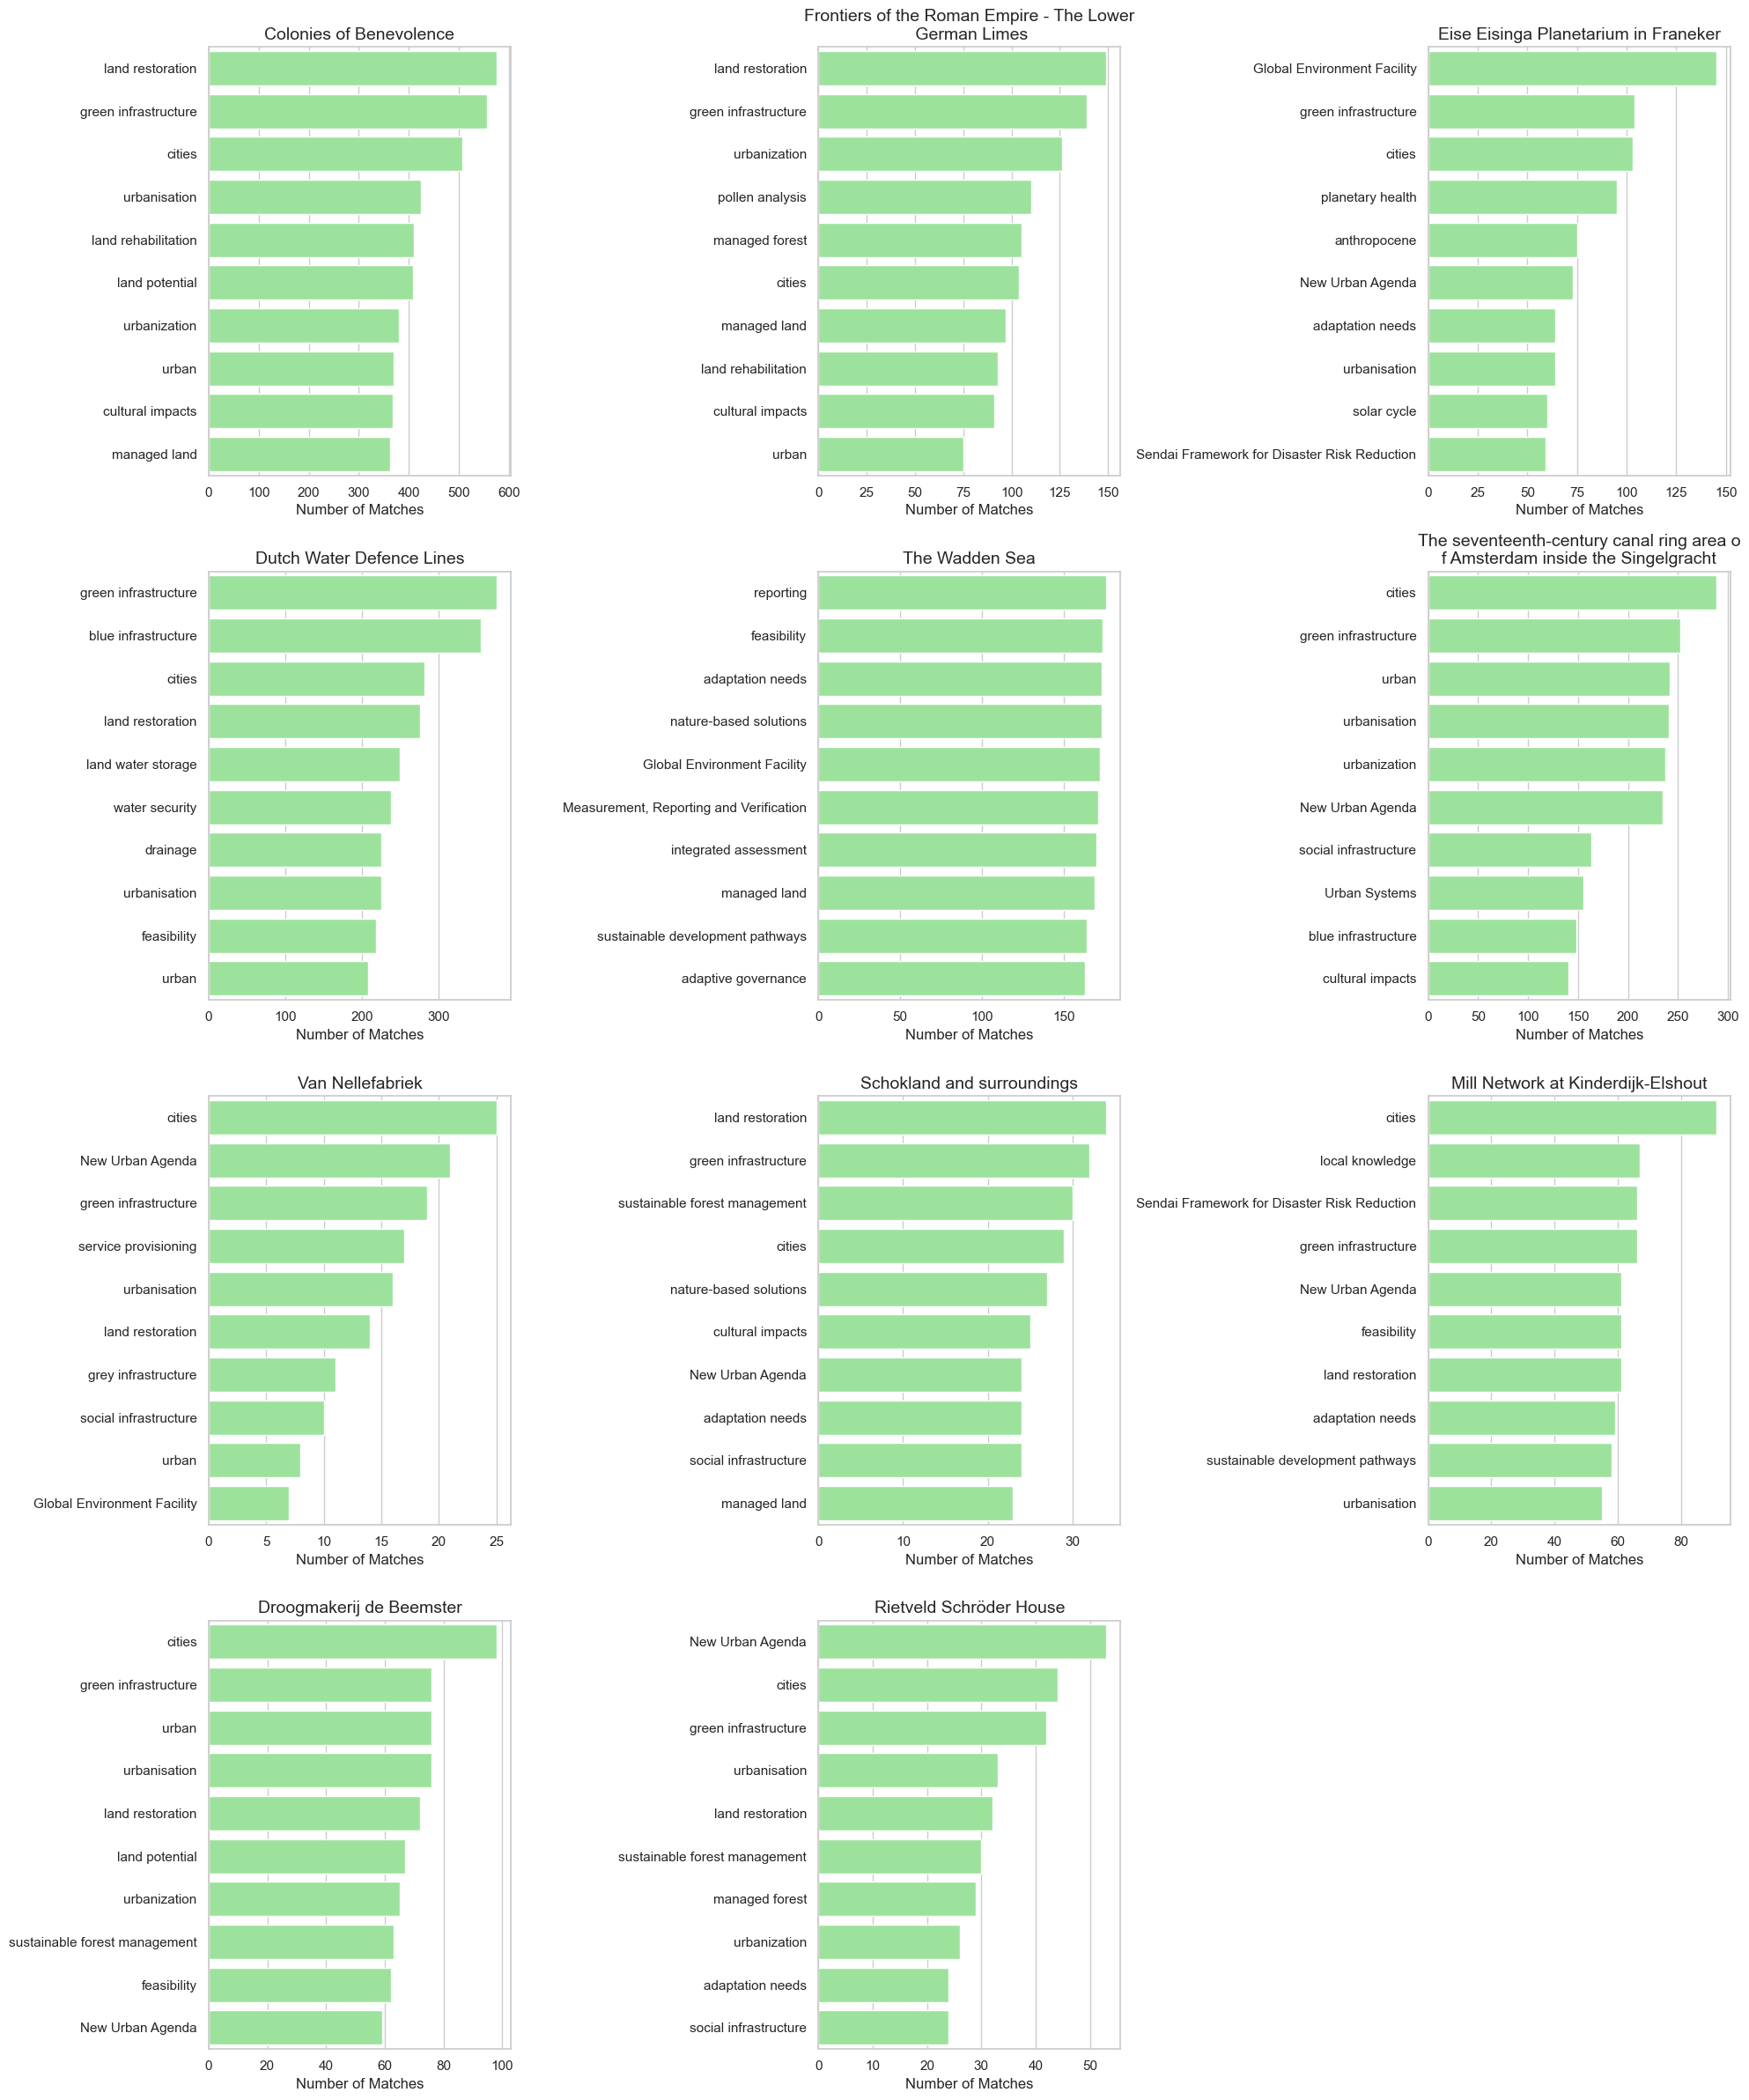

In [5]:

# We counting the number of rows, which corresponds to the number of chunks where the concept was found
df_counts = df_mpnet.groupby(['MP Index', 'Concept']).size().reset_index(name='Match_Count')

# Sorting by MP Index and Count, then selecting top 10 per MP Index
top_concepts_counts = df_counts.sort_values(
    ['MP Index', 'Match_Count'], 
    ascending=[True, False]
).groupby('MP Index').head(10)

# Creating the visualization, same as before but for counts
unique_mps = sorted(top_concepts_counts['MP Index'].unique())
n_cols = 3
n_rows = (len(unique_mps) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), sharex=False)
axes = axes.flatten()

for i, mp_idx in enumerate(unique_mps):
    ax = axes[i]
    data = top_concepts_counts[top_concepts_counts['MP Index'] == mp_idx]
    
    # Creating horizontal bar chart
    sns.barplot(x='Match_Count', y='Concept', data=data, ax=ax, color='lightgreen')
    
    # Use the mapping for the title
    site_name = mp_mapping.get(mp_idx, f"MP Index {mp_idx}")
    # Wrap text for long titles so they don't overlap
    title = "\n".join([site_name[i:i+41] for i in range(0, len(site_name), 41)])
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Number of Matches')
    ax.set_ylabel('')

# Remove any unused subplots (the twelfth subplot in this case)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('top_concepts_counts_per_site_mpnet.png')
plt.show()

Unique chunks per MP

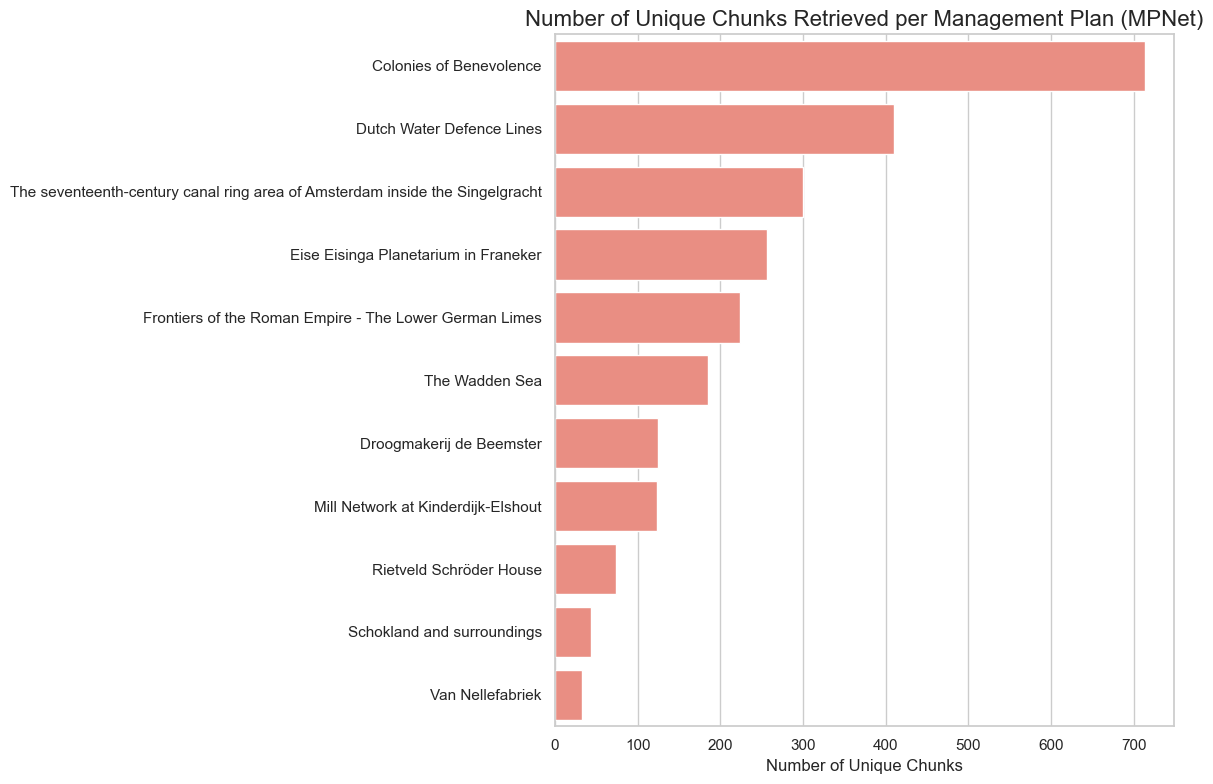

In [6]:
# Counting amount of unique chunks per MP Index
unique_chunks_per_mp = df_mpnet.groupby('MP Index')['Chunk ID'].nunique().reset_index(name='Unique_Chunks')

# Map MP Index to Site Name
unique_chunks_per_mp['Site_Name'] = unique_chunks_per_mp['MP Index'].map(mp_mapping)

# Sorting by count for better visualization (descending order)
unique_chunks_per_mp = unique_chunks_per_mp.sort_values('Unique_Chunks', ascending=False)

#Creating the visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Unique_Chunks', y='Site_Name', data=unique_chunks_per_mp, color='salmon')

plt.title('Number of Unique Chunks Retrieved per Management Plan (MPNet)', fontsize=16)
plt.xlabel('Number of Unique Chunks', fontsize=12)
plt.ylabel('')
plt.savefig('unique_chunks_per_mp.png')
plt.tight_layout()

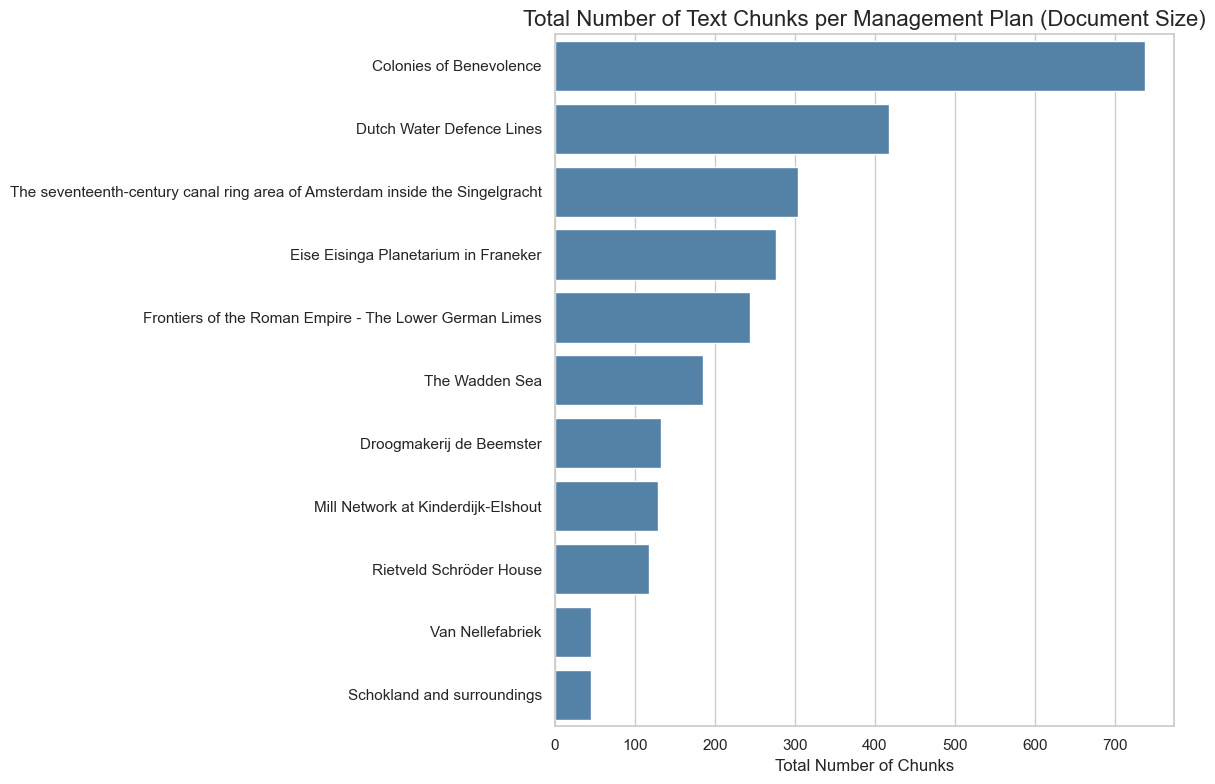

In [7]:
#Gettimg total number of chunks per MP Index
# We assume Chunk IDs are sequential. The total size is estimated by the range (max - min + 1).
chunk_counts = df_mpnet.groupby('MP Index')['Chunk ID'].agg(['min', 'max'])
chunk_counts['Total_Chunks'] = chunk_counts['max'] - chunk_counts['min'] + 1
chunk_counts = chunk_counts.reset_index()

# Mapping the site names
chunk_counts['Site_Name'] = chunk_counts['MP Index'].map(mp_mapping)

# Sorting by size for better visualization
chunk_counts = chunk_counts.sort_values('Total_Chunks', ascending=False)

#Creating the Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Chunks', y='Site_Name', data=chunk_counts, color='steelblue')

plt.title('Total Number of Text Chunks per Management Plan (Document Size)', fontsize=16)
plt.xlabel('Total Number of Chunks', fontsize=12)
plt.ylabel('')
plt.tight_layout()

plt.savefig('total_chunks_per_site.png')
plt.show()

In [24]:
#Comparing Unique Retrieved Chunks vs Total Document Size because the difference is small

# Merge the two DataFrames on 'MP Index'
comparison = pd.merge(unique_chunks_per_mp, chunk_counts[['MP Index', 'Total_Chunks']], on='MP Index')

# The difference between total size and what was retrieved.
comparison['Unmatched_Chunks'] = comparison['Total_Chunks'] - comparison['Unique_Chunks']

# Adding the Site Name column
comparison['Site_Name'] = comparison['MP Index'].map(mp_mapping)

# Reordering columns for better readability
final_table = comparison[['Site_Name', 'Total_Chunks', 'Unique_Chunks', 'Unmatched_Chunks']]

totals = final_table[['Total_Chunks', 'Unique_Chunks', 'Unmatched_Chunks']].sum()

# Creating a new DataFrame for the totals row
totals_row = pd.DataFrame([[
    'Total', 
    totals['Total_Chunks'], 
    totals['Unique_Chunks'], 
    totals['Unmatched_Chunks']
]], columns=final_table.columns)

# Appending the Totals row to the main table
final_table_with_total = pd.concat([final_table, totals_row], ignore_index=True)

#  Displaying
final_table_with_total

,Site_Name,Total_Chunks,Unique_Chunks,Unmatched_Chunks
0,Colonies of Benevolence,737,713,24
1,Frontiers of the Roman Empire - The Lower Germ...,244,224,20
2,Eise Eisinga Planetarium in Franeker,276,256,20
3,Dutch Water Defence Lines,418,410,8
4,The Wadden Sea,185,185,0
5,The seventeenth-century canal ring area of Ams...,304,300,4
6,Van Nellefabriek,45,33,12
7,Schokland and surroundings,45,43,2
8,Mill Network at Kinderdijk-Elshout,129,123,6
9,Droogmakerij de Beemster,132,124,8


In [ ]:
# calculating percentage matched
total_all = comparison['Total_Chunks'].sum()
unique_all = comparison['Unique_Chunks'].sum()
global_percentage = (unique_all / total_all) * 100
print(f"\nTotal Percentage of Chunks Matched (Average across all MP's): {global_percentage:.1f}%")


Total Percentage of Chunks Matched (Average across all files): 94.4%


The Sankey Diagram

In [ ]:
import matplotlib.patches as patches #Reference for sankey diagram: https://matplotlib.org/stable/api/patches_api.html
import matplotlib.path as mpath
import numpy as np

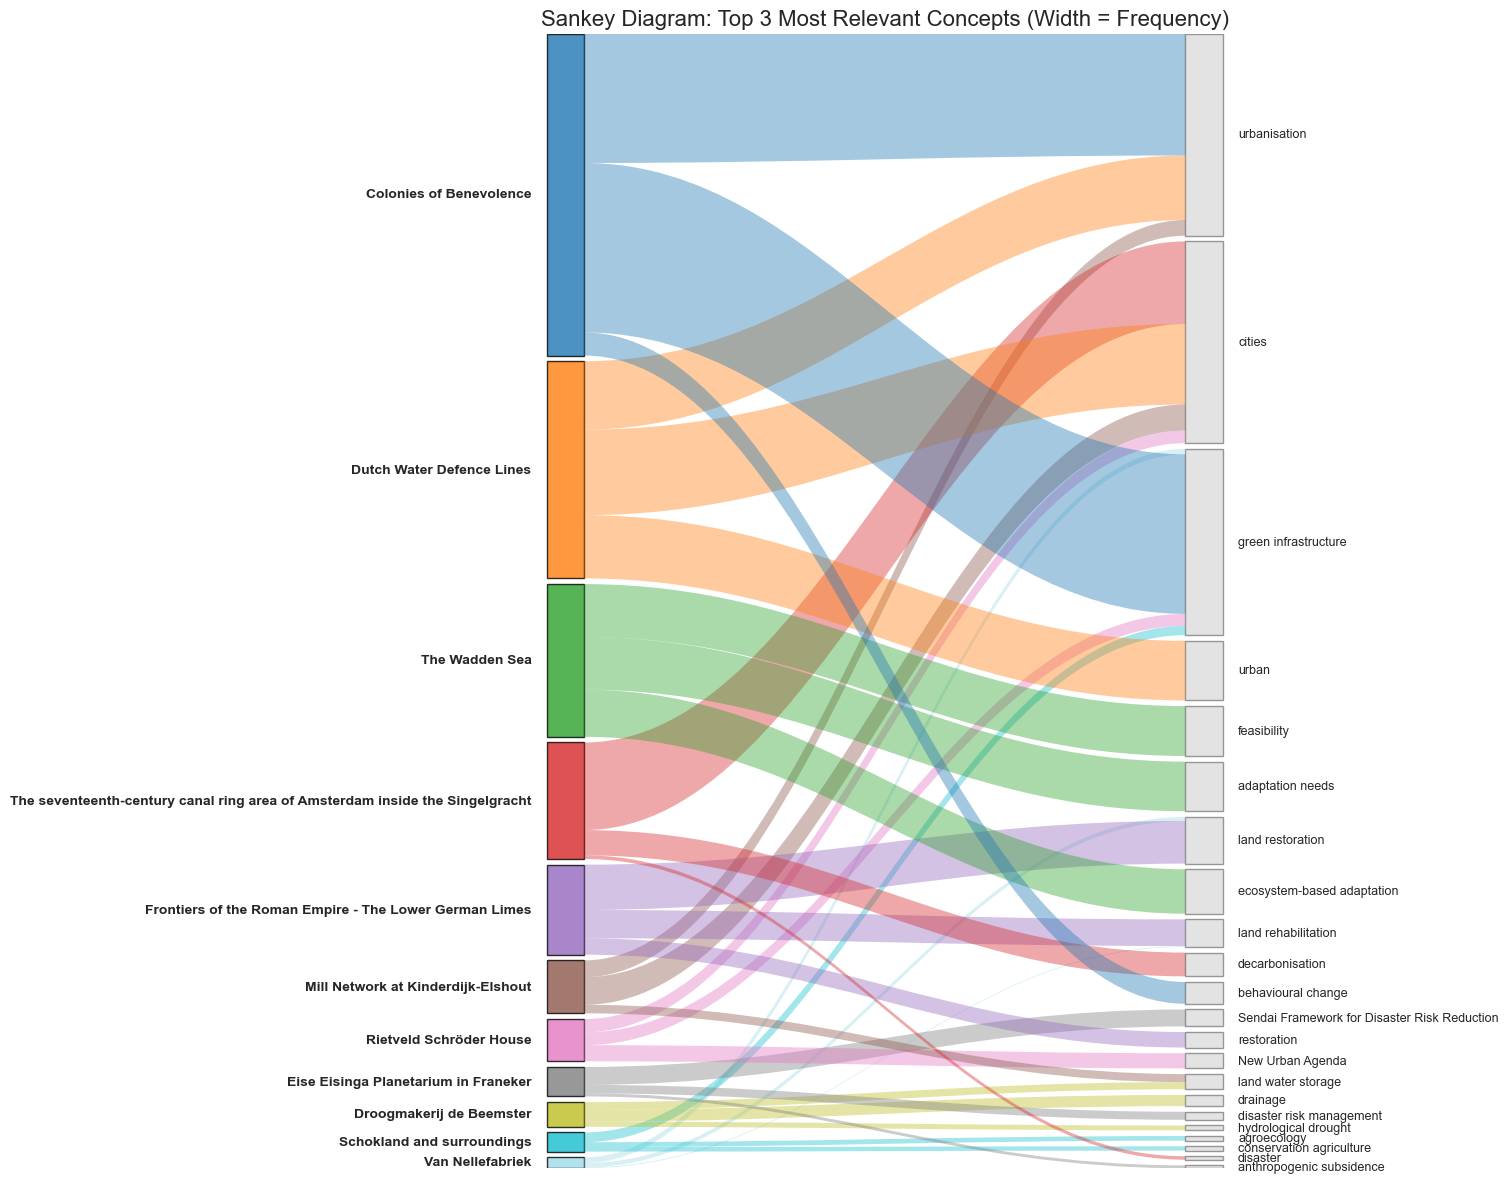

In [ ]:
# this script is meanly based on AI generated code

#____________________________________________________________________________________________________________________________________________________________
#GETTING DATA FOR THE SANKEY DIAGRAM

# Counting the amount of matches for each Concept per MP
df_metrics = df_mpnet.groupby(['MP Index', 'Concept']).agg(
    Max_Z_Score=('Z_Score', 'max'), # Getting the maximum Z-Score per Concept per MP Index
    Count=('Chunk ID', 'count') # Counting the number of matches (chunks) per Concept per MP Index
).reset_index()

# Selecting Data for Plotting based on Relevance (Z-Score)
top_n = 3 # Top N concepts per MP Index
top_flows = df_metrics.sort_values(
    ['MP Index', 'Max_Z_Score'], 
    ascending=[True, False]
).groupby('MP Index').head(top_n)

# Mapping MP Index to Name
top_flows['MP Name'] = top_flows['MP Index'].map(mp_mapping)


#_____________________________________________________________________________________________________________________________________________
#CREATING THE SANKEY DIAGRAM LAYOUT

# Calculating total counts to determine bar heights
mp_totals = top_flows.groupby('MP Name')['Count'].sum().sort_values(ascending=False)
concept_totals = top_flows.groupby('Concept')['Count'].sum().sort_values(ascending=False)
mps = mp_totals.index.tolist()
concepts = concept_totals.index.tolist()

# Defining layout parameters
padding = 5
plot_height = 1000
total_value = top_flows['Count'].sum()

# Calculating scaling factors
left_scale = (plot_height - (len(mps) - 1) * padding) / total_value
right_scale = (plot_height - (len(concepts) - 1) * padding) / total_value

# Calculate Y positions for MP bars (Left side)
mp_y_positions = {}
current_y = plot_height
for mp in mps:
    h = mp_totals[mp] * left_scale
    mp_y_positions[mp] = {'top': current_y, 'bottom': current_y - h, 'height': h, 'center': current_y - h/2}
    current_y -= (h + padding)

# Calculate Y positions for Concept bars (Right side)
concept_y_positions = {}
current_y = plot_height
for c in concepts:
    h = concept_totals[c] * right_scale
    concept_y_positions[c] = {'top': current_y, 'bottom': current_y - h, 'height': h, 'center': current_y - h/2}
    current_y -= (h + padding)

# --- 4. Draw the Plot ---
fig, ax = plt.subplots(figsize=(15, 12))
ax.set_xlim(0, 100)
ax.set_ylim(0, plot_height)
ax.axis('off')

# Colors
colors = plt.cm.tab20(np.linspace(0, 1, len(mps)))
mp_colors = {mp: color for mp, color in zip(mps, colors)}

left_x, right_x = 10, 90
bar_width = 5

# Draw MP Bars (Left)
for mp in mps:
    pos = mp_y_positions[mp]
    rect = patches.Rectangle((left_x - bar_width, pos['bottom']), bar_width, pos['height'], 
                             facecolor=mp_colors[mp], edgecolor='black', alpha=0.8)
    ax.add_patch(rect)
    ax.text(left_x - bar_width - 2, pos['center'], mp, ha='right', va='center', fontsize=10, fontweight='bold')

# Draw Concept Bars (Right)
for c in concepts:
    pos = concept_y_positions[c]
    rect = patches.Rectangle((right_x, pos['bottom']), bar_width, pos['height'], 
                             facecolor='#dddddd', edgecolor='gray', alpha=0.8)
    ax.add_patch(rect)
    ax.text(right_x + bar_width + 2, pos['center'], c, ha='left', va='center', fontsize=9)

# Draw Flows (Ribbons)
mp_current_y = {mp: mp_y_positions[mp]['top'] for mp in mps}
concept_current_y = {c: concept_y_positions[c]['top'] for c in concepts}

# Sort flows to reduce visual clutter
top_flows['Concept_Y'] = top_flows['Concept'].map(lambda x: concept_y_positions[x]['center'])
top_flows_sorted = top_flows.sort_values('Concept_Y', ascending=False)

for _, row in top_flows_sorted.iterrows():
    mp = row['MP Name']
    conc = row['Concept']
    val = row['Count']
    
    # Calculate ribbon height
    h_left = val * left_scale
    h_right = val * right_scale
    
    # Coordinates
    y1_top = mp_current_y[mp]
    y1_bot = y1_top - h_left
    y2_top = concept_current_y[conc]
    y2_bot = y2_top - h_right
    
    # Update pointers
    mp_current_y[mp] = y1_bot
    concept_current_y[conc] = y2_bot
    
    # --- MANUAL PATH CONSTRUCTION (FIXED) ---
    p1 = (left_x, y1_top)      # Top Left
    p2 = (right_x, y2_top)     # Top Right
    p3 = (right_x, y2_bot)     # Bot Right
    p4 = (left_x, y1_bot)      # Bot Left
    
    dist = right_x - left_x
    
    # Control points for top curve (Left to Right)
    cp1_top = (left_x + dist * 0.4, y1_top)
    cp2_top = (right_x - dist * 0.4, y2_top)
    
    # Control points for bottom curve (Right to Left)
    cp1_bot = (right_x - dist * 0.4, y2_bot)
    cp2_bot = (left_x + dist * 0.4, y1_bot)
    
    path_data = [
        (mpath.Path.MOVETO, p1),
        (mpath.Path.CURVE4, cp1_top),
        (mpath.Path.CURVE4, cp2_top),
        (mpath.Path.CURVE4, p2),
        (mpath.Path.LINETO, p3),
        (mpath.Path.CURVE4, cp1_bot),
        (mpath.Path.CURVE4, cp2_bot),
        (mpath.Path.CURVE4, p4),
        (mpath.Path.CLOSEPOLY, p1)
    ]
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
    patch = patches.PathPatch(path, facecolor=mp_colors[mp], alpha=0.4, edgecolor='none')
    ax.add_patch(patch)

plt.title("Sankey Diagram: Top 3 Most Relevant Concepts (Width = Frequency)", fontsize=16)
plt.tight_layout()
plt.savefig('sankey_diagram_mp_concepts.png')
plt.show()